In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from train_utils import *
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix

import uproot
from root_pandas import read_root


import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

Welcome to JupyROOT 6.22/02
You are running on  wudangshan


In [2]:
# Load the data
useRootInput=True

data_tth_orig=None
if useRootInput: # the default
    # Use uproot
    idir = '{}'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')

    file_tth = "{}/tree_2lss1tau.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)


In [3]:
data_tth_orig.describe()

,Lep1_pt,Lep2_pt,Lep1_eta,Lep2_eta,Lep1_phi,Lep2_phi,nSelJets,event,met,met_phi,...,dEtaBB_L1L2frame_3l,dEtaBB_L1L3frame_3l,mTTH_2lss,mTTH_3l,mTTH_2lss1tau,theta_higgs_ttbar_TTHsystem_2lss1tau,thetaTopTop_ttbarframe_2lss1tau,Tau_pt,Tau_eta,Tau_phi
count,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,4.358400e+04,43584.000000,43584.000000,...,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000,43584.000000
mean,80.776611,37.814930,0.002453,0.002778,0.009698,-0.012621,3.858962,1.104320e+07,95.950638,0.079891,...,0.021208,0.018829,704.115540,16.791822,626.536743,2.852836,1.595816,52.566780,-0.001968,-0.008276
std,50.277542,21.778221,1.009635,1.042978,1.817238,1.817694,1.315551,8.494279e+06,63.805481,1.777812,...,0.175773,0.161523,342.322021,113.695068,301.597656,0.568078,0.773292,38.913521,0.989887,1.809748
min,25.002064,15.000173,-2.493652,-2.496582,-3.141113,-3.141113,1.000000,2.950000e+02,0.327500,-3.141602,...,0.000000,0.000000,79.429489,0.000000,97.485649,0.031558,0.013652,20.001446,-2.298828,-3.141113
25%,46.735332,23.226981,-0.725006,-0.752838,-1.564453,-1.585205,3.000000,4.166240e+06,51.632649,-1.412231,...,0.000000,0.000000,474.850861,0.000000,427.345772,2.802256,0.942415,28.262776,-0.721344,-1.576050
50%,67.278522,31.824586,0.002304,0.005653,0.010266,-0.030504,4.000000,8.431546e+06,83.017204,0.146774,...,0.000000,0.000000,623.555298,0.000000,555.843872,3.141593,1.583337,40.058958,0.003815,-0.012947
75%,98.878178,45.413179,0.726196,0.760193,1.595947,1.562378,5.000000,1.762415e+07,124.330141,1.575500,...,0.000000,0.000000,841.510635,0.000000,743.594391,3.141593,2.249774,62.217653,0.718384,1.561523
max,699.348083,359.891205,2.497070,2.494141,3.141602,3.141113,12.000000,2.999971e+07,884.521484,3.141113,...,4.344077,4.345463,4299.568359,2204.222168,4147.984375,3.141593,3.135246,642.759155,2.299805,3.141602


In [4]:
# De-jag it

data_tth=data_tth_orig # save the original

test=data_tth['SelJet_pt']
l = [len(i) for i in test]
maxl = max(l)

for lab in ['pt', 'eta', 'phi', 'mass', 'isBtag', 'isFromHadTop', 'btagDeepFlavB']:
    label='SelJet_%s'%lab
    tempLab=data_tth[label]
    data_tth.drop([label], axis=1, inplace=True)
    out = pd.DataFrame(tempLab.tolist(),columns=[ 'SelJet%s_%s'%(i, lab) for i in range(maxl)])
    data_tth = pd.concat([data_tth, out], axis=1)


In [5]:
# Remove ill-defined mass columns

for lab in data_tth.columns:
    if 'mass' in lab:
        data_tth.drop([lab], axis=1, inplace=True)

In [6]:
print(data_tth_orig.columns)

print(maxl)

print(data_tth.columns)

Index(['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
       'nSelJets', 'SelJet_eta', 'SelJet_phi', 'SelJet_mass', 'SelJet_isBtag',
       'SelJet_isFromHadTop', 'SelJet_btagDeepFlavB', 'event', 'met',
       'met_phi', 'Higgs_y', 'Higgs_pt', 'weight_SM', 'weight_CP_odd',
       'weight_CP_mixed', 'HTT_score', 'mT_lep2', 'mT_lep1',
       'Hj_tagger_hadTop', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
       'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
       'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'dEtaL1L2_BBframe_3l',
       'dEtaL1L3_BBframe_3l', 'dEtaBB_L1L2frame_3l', 'dEtaBB_L1L3frame_3l',
       'mTTH_2lss', 'mTTH_3l', 'mTTH_2lss1tau',
       'theta_higgs_ttbar_TTHsystem_2lss1tau',
       'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta', 'Tau_phi'],
      dtype='object')
12
Index(['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
       'nSelJets', 'event', 'met', 'met_phi',
       ...
       'SelJet2_

In [7]:
#thevars=['Lep1_pt', 'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
#               'met', 'met_phi', 'Tau_pt', 'Tau_eta', 'Tau_phi', 'HTT_score']
#for i in range(12):
#    thevars.append('SelJet%s_pt'%i)
#    thevars.append('SelJet%s_eta'%i)
#    thevars.append('SelJet%s_phi'%i)
#    thevars.append('SelJet%s_mass'%i)
#    thevars.append('SelJet%s_isBtag'%i)
#    thevars.append('SelJet%s_isFromHadTop'%i)

thevars=[
        'Lep1_pt', 
    #'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
        # 'nSelJets',
        # 'met', 'met_phi', 
        # 'HTT_score', 
        # 'Hj_tagger_hadTop',
        # 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
        # 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
        # 'dEtaBB_LLframe_2lss',
        'dEtaBB_2lss',
        # 'mTTH_2lss1tau',
         #'theta_higgs_ttbar_TTHsystem_2lss1tau',
         'thetaTopTop_ttbarframe_2lss1tau', 
        # 'Tau_pt', 'Tau_eta', 'Tau_phi'
    ]
#for i in range(12):
#    thevars.append('SelJet%s_pt'%i)
#    thevars.append('SelJet%s_eta'%i)
#    thevars.append('SelJet%s_phi'%i)
##    thevars.append('SelJet%s_mass'%i)
#    thevars.append('SelJet%s_isBtag'%i)
#    thevars.append('SelJet%s_isFromHadTop'%i)
#    thevars.append('SelJet%s_btagDeepFlavB'%i)
    
spect=['event', 'Higgs_y', 'Higgs_pt', 'weight_SM', 'weight_CP_odd']


print('Training features:', thevars)
print('Spectator features:', spect)

Training features: ['Lep1_pt', 'dEtaBB_2lss', 'thetaTopTop_ttbarframe_2lss1tau']
Spectator features: ['event', 'Higgs_y', 'Higgs_pt', 'weight_SM', 'weight_CP_odd']


In [8]:
print(thevars)
bkg = data_tth[thevars]
sig = data_tth[thevars]

bkg.fillna(0, inplace=True)
sig.fillna(0, inplace=True)


wgtbkg=pd.DataFrame(data_tth['weight_SM'].tolist(), columns=['weight'])
wgtsig=pd.DataFrame(data_tth['weight_CP_odd'].tolist(), columns=['weight'])


#bkg['weight']=data_tth.iloc[:,data_tth.columns.get_loc('weight_SM')]
#sig['weight']=data_tth.iloc[:,data_tth.columns.get_loc('weight_CP_odd')]

labbkg = pd.DataFrame(np.zeros_like(bkg['Lep1_pt']).tolist(), columns=['label'])
labsig = pd.DataFrame(np.ones_like(bkg['Lep1_pt']).tolist(), columns=['label'])


bkg = pd.concat([bkg, wgtbkg, labbkg], axis=1)
sig = pd.concat([sig, wgtsig, labsig], axis=1)

bkg.head()
#sig = sig[sig['weight']<20]
sig['weight'] = sig['weight'].apply(lambda x: x if x <10. else 10.)
#print(bkg.columns)

labelled_set=pd.concat([sig, bkg], axis=0)

labelled_set=shuffle(labelled_set)


labs=thevars
labs.append('weight')
X=labelled_set[labs]
y=labelled_set['label']
weight=labelled_set['weight']

pd.set_option('display.max_columns', None)
#labelled_set.head()

/home/junzi/.local/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


['Lep1_pt', 'dEtaBB_2lss', 'thetaTopTop_ttbarframe_2lss1tau']


In [9]:

print(bkg.head())

print(sig.head())


      Lep1_pt  dEtaBB_2lss  thetaTopTop_ttbarframe_2lss1tau  weight  label
0   65.060692     0.161133                         0.032951     1.0    0.0
1  116.764389     0.680908                         1.037256     1.0    0.0
2   81.278633     0.471680                         0.294684     1.0    0.0
3  125.633125     1.503662                         1.459926     1.0    0.0
4   51.864380     1.458496                         0.666432     1.0    0.0
      Lep1_pt  dEtaBB_2lss  thetaTopTop_ttbarframe_2lss1tau    weight  label
0   65.060692     0.161133                         0.032951  0.198509    1.0
1  116.764389     0.680908                         1.037256  0.020307    1.0
2   81.278633     0.471680                         0.294684  0.034626    1.0
3  125.633125     1.503662                         1.459926  0.170105    1.0
4   51.864380     1.458496                         0.666432  0.232780    1.0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1534534, shuffle=True)

X_train_wgt=X_train['weight']
X_train=X_train.drop(['weight'], axis=1, inplace=False)
X_test_wgt=X_test['weight']
X_test=X_test.drop(['weight'], axis=1, inplace=False)

train_dmatrix = xgb.DMatrix(data=X_train,label=y_train,weight=X_train_wgt)
test_dmatrix = xgb.DMatrix(data=X_test,label=y_test,weight=X_test_wgt)

#perm = np.random.permutation(len(X_train))
#X_train = X_train[perm]
#y_train = y_train[perm]
#X_train_wgt = X_train_wgt[perm]

#perm = np.random.permutation(len(X_train))
#X_test = X_test[perm]
#y_test = y_test[perm]
#X_test_wgt = X_test_wgt[perm]


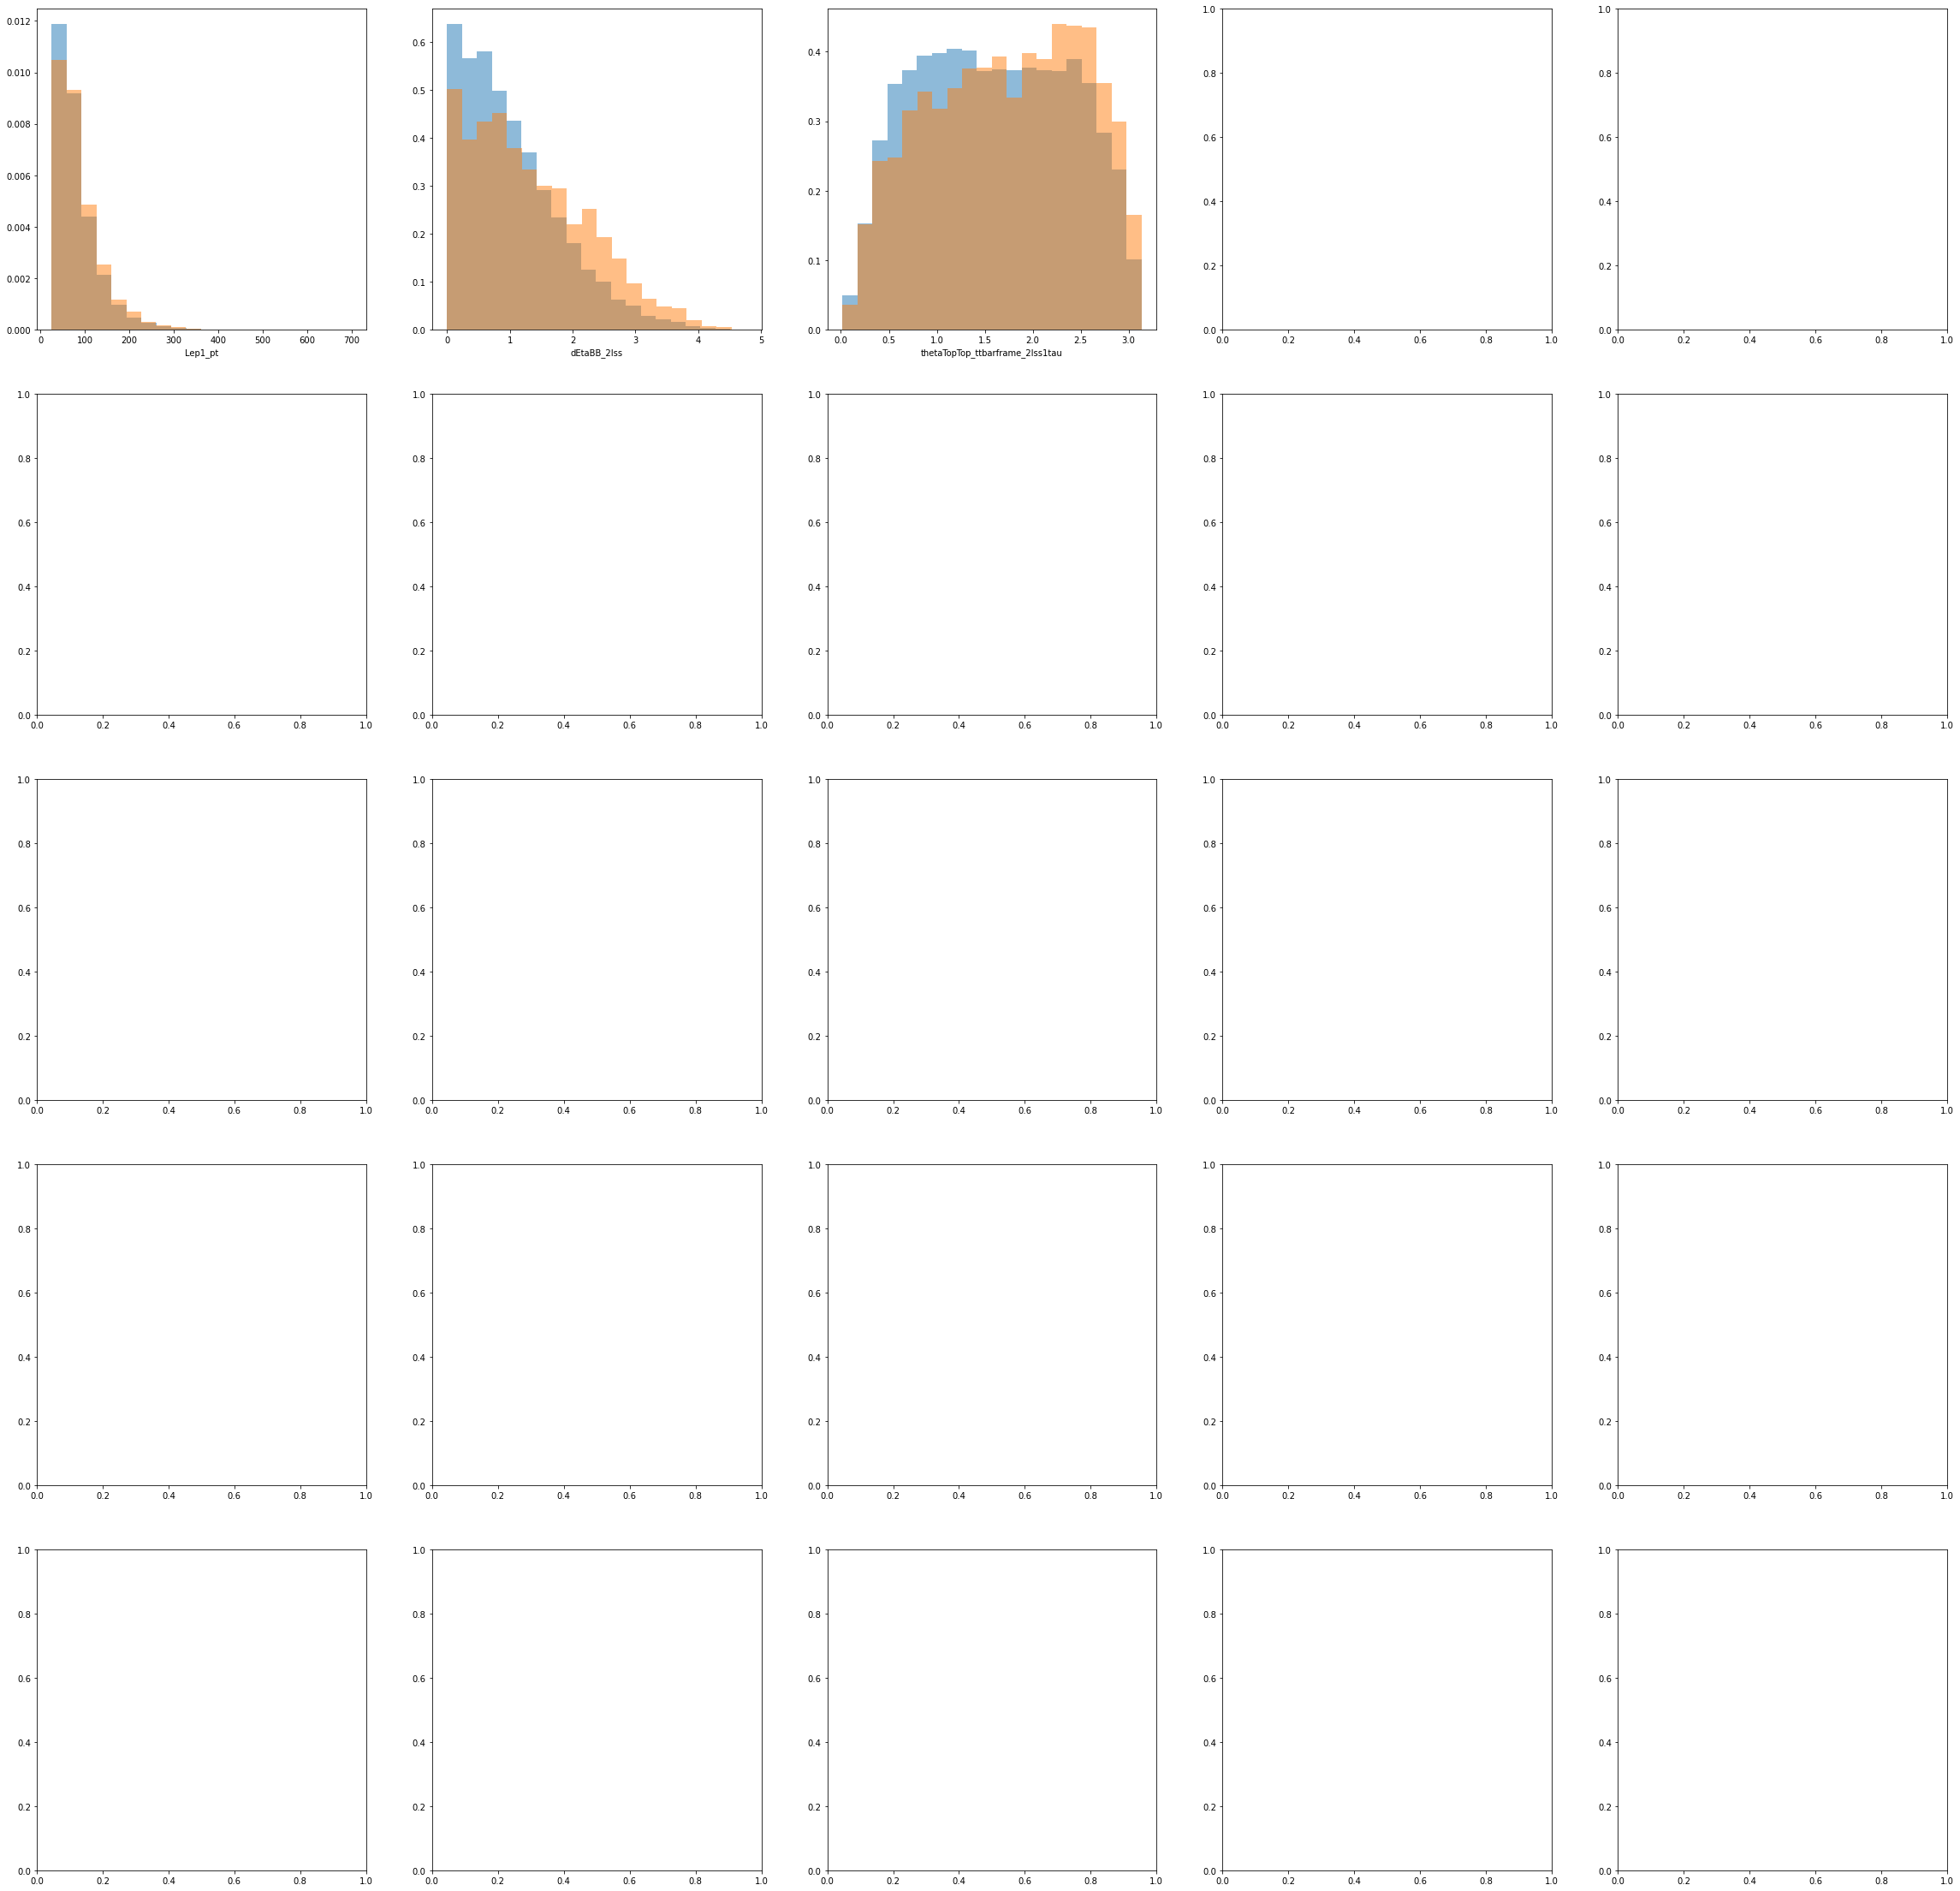

In [11]:
fix, axs= plt.subplots(5,5, figsize=(40,40))
axs = axs.ravel()

for i,ax in enumerate(axs):
    if i >= len(thevars):
        continue
    var=thevars[i]
    if var=='weight':
        continue
    ax=axs[i]
    #ax.hist(X_train[var], label='%s'%var)
    ax.hist(X_train[var][y_train[:]==0 ], weights=X_train_wgt[y_train[:]==0 ], density=True, alpha=0.5, bins=20)
    ax.hist(X_train[var][y_train[:]==1 ], weights=X_train_wgt[y_train[:]==1 ], density=True, alpha=0.5, bins=20)
    #ax.set_yscale('log')
    ax.set_xlabel(var)



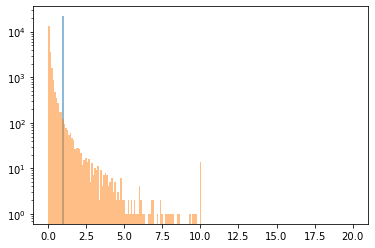

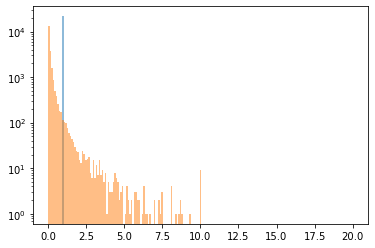

In [12]:
plt.hist(X_train_wgt[y_train[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.yscale("log")
plt.hist(X_train_wgt[y_train[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.show()
#plt.hist(X)
plt.hist(X_test_wgt[y_test[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.yscale("log")
plt.hist(X_test_wgt[y_test[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
plt.show()

In [13]:
pd.set_option('display.max_columns', None)
X_train.head()

#import seaborn as sns
#sns.pairplot(labelled_set, hue='label')  
print(X_train.columns)
print(X_train_wgt[y_train[:]==0])

score_test=None

Index(['Lep1_pt', 'dEtaBB_2lss', 'thetaTopTop_ttbarframe_2lss1tau'], dtype='object')
7120     1.0
39906    1.0
34116    1.0
7118     1.0
39259    1.0
        ... 
38194    1.0
16460    1.0
35391    1.0
26035    1.0
35547    1.0
Name: weight, Length: 21876, dtype: float64


In [67]:
gradb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_depth=3, random_state=7)
gradb.fit(X_train, y_train, sample_weight=X_train_wgt)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=20, random_state=7)

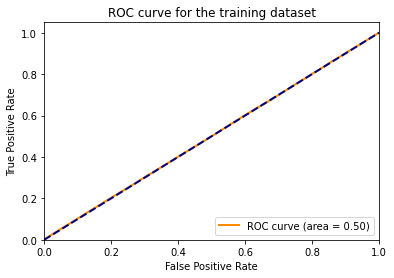

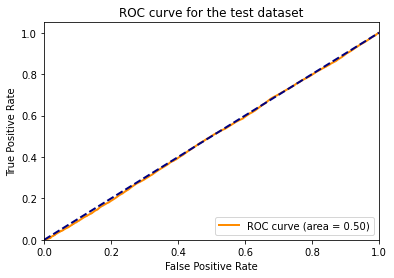

Confusion Matrix:
train [[34868    48]
 [34741    77]]
Confusion Matrix:
test [[8631   37]
 [8758    8]]


In [68]:
preds_train = gradb.predict(X_train)
preds_test =  gradb.predict(X_test)
score_train = gradb.predict_proba(X_train)[:,1]
score_test = gradb.predict_proba(X_test)[:,1]


plot_roc(y_train, score_train, 'training')
plot_roc(y_test, score_test, 'test')


print("Confusion Matrix:")
print('train', confusion_matrix(y_train, preds_train))

print("Confusion Matrix:")
print('test', confusion_matrix(y_test, preds_test))

In [15]:
print(type(X_train_wgt))

<class 'pandas.core.series.Series'>


In [14]:
#
#xg_class = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='aucpr', colsample_bytree = 0.1, learning_rate = 0.1,
#                max_depth = 5, n_estimators = 1000, verbosity=0)

#xg_class = xgb.XGBClassifier(objective ='binary:logistic', alpha=10, n_estimators=1000, max_depth=4, learning_rate=0.1, verbosity=0)

#xg_class = xgb.XGBClassifier(objective ='binary:logistic', alpha=2, n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=0)
xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
#early_stopping_rounds=10
xg_class.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])


[0]	validation_0-error:0.17475	validation_0-logloss:0.65168	validation_1-error:0.17804	validation_1-logloss:0.65225
[1]	validation_0-error:0.17460	validation_0-logloss:0.61785	validation_1-error:0.17758	validation_1-logloss:0.61894
[2]	validation_0-error:0.17460	validation_0-logloss:0.58994	validation_1-error:0.17758	validation_1-logloss:0.59152
[3]	validation_0-error:0.17460	validation_0-logloss:0.56671	validation_1-error:0.17758	validation_1-logloss:0.56874
[4]	validation_0-error:0.17423	validation_0-logloss:0.54813	validation_1-error:0.17762	validation_1-logloss:0.55056
[5]	validation_0-error:0.17460	validation_0-logloss:0.53202	validation_1-error:0.17758	validation_1-logloss:0.53497
[6]	validation_0-error:0.17460	validation_0-logloss:0.51892	validation_1-error:0.17758	validation_1-logloss:0.52222
[7]	validation_0-error:0.17460	validation_0-logloss:0.50780	validation_1-error:0.17758	validation_1-logloss:0.51158
[8]	validation_0-error:0.17460	validation_0-logloss:0.49827	validation_1

[71]	validation_0-error:0.17389	validation_0-logloss:0.44189	validation_1-error:0.17766	validation_1-logloss:0.45917
[72]	validation_0-error:0.17389	validation_0-logloss:0.44182	validation_1-error:0.17766	validation_1-logloss:0.45918
[73]	validation_0-error:0.17389	validation_0-logloss:0.44171	validation_1-error:0.17766	validation_1-logloss:0.45923
[74]	validation_0-error:0.17389	validation_0-logloss:0.44157	validation_1-error:0.17766	validation_1-logloss:0.45934
[75]	validation_0-error:0.17389	validation_0-logloss:0.44150	validation_1-error:0.17766	validation_1-logloss:0.45936
[76]	validation_0-error:0.17389	validation_0-logloss:0.44141	validation_1-error:0.17766	validation_1-logloss:0.45940
[77]	validation_0-error:0.17389	validation_0-logloss:0.44127	validation_1-error:0.17766	validation_1-logloss:0.45941
[78]	validation_0-error:0.17389	validation_0-logloss:0.44119	validation_1-error:0.17766	validation_1-logloss:0.45942
[79]	validation_0-error:0.17389	validation_0-logloss:0.44107	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
#eval_set = [train_dmatrix, test_dmatrix ]
#
#params = {
#    'max_depth': 6,
#    'objective': 'binary:logistic',
#    'eval_metric': ['error', 'logloss'],
#    'eval_set': eval_set
#}

#xg_class = xgb.train(params, train_dmatrix)


In [16]:
#pred = xg_class.predict(test_dmatrix)
#pred=np.asarray([np.argmax(line) for line in pred])

#cm = confusion_matrix(y_test, pred)
#import seaborn as sns
#def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
#    plt.figure(figsize=[7, 6])
#    norm_cm = cm
#    if normalized:
#        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

#plot_confusion_matrix(cm, ['CP odd', 'CP even'])

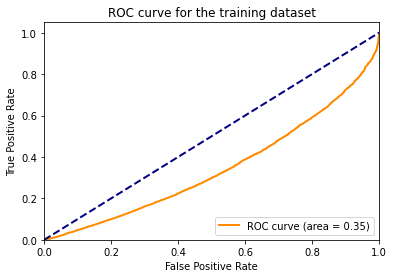

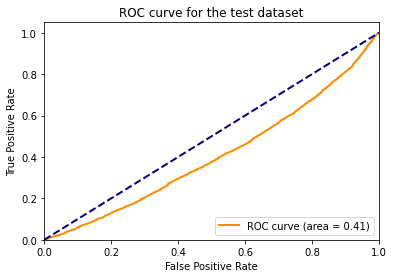

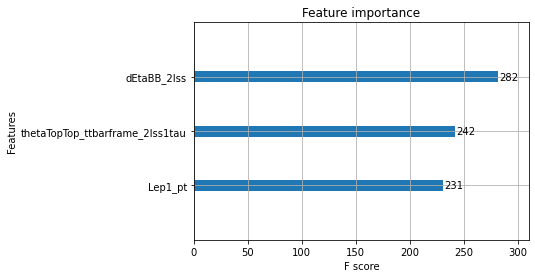

<Figure size 1152x864 with 0 Axes>

Accuracy (train): 50.21%
Accuracy (test): 49.79%


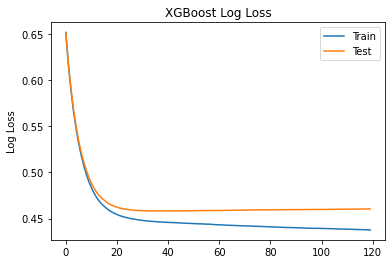

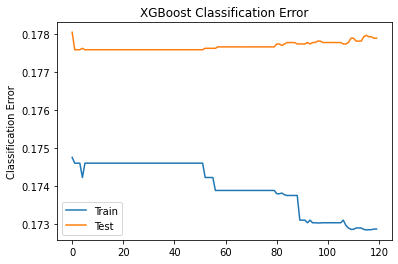

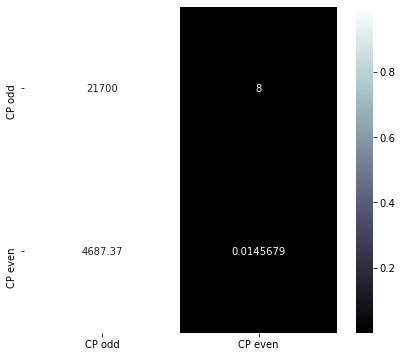

In [18]:

preds_train = xg_class.predict_proba(X_train)[:,0]
preds_test = xg_class.predict_proba(X_test)[:,0]

#preds_train=np.argmax(xg_class.predict_proba(X_train), axis=1)
#preds_test =np.argmax(xg_class.predict_proba(X_test), axis=1)

preds_cat_train = xg_class.predict(X_train)
preds_cat_test  = xg_class.predict(X_test)
# ROC curves
sample_weight=X_train_wgt
plot_roc(y_train, preds_train, sample_weight=X_train_wgt, label='training')
plot_roc(y_test, preds_test, sample_weight=X_test_wgt, label='test')



xgb.plot_importance(xg_class)
plt.figure(figsize = (16, 12))
plt.show()
accuracy_train = accuracy_score(y_train, preds_cat_train)
print("Accuracy (train): %.2f%%" % (accuracy_train * 100.0))
accuracy_test = accuracy_score(y_test, preds_cat_test)
print("Accuracy (test): %.2f%%" % (accuracy_test * 100.0))


results = xg_class.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


#pred=np.asarray([np.argmax(line) for line in pred])
#Confusion matrix whose i-th row and j-th column entry indicates
# the number of samples with true label being i-th class and prediced label being j-th class.
import seaborn as sns
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

cm = confusion_matrix(y_test, preds_cat_test, sample_weight=X_test_wgt)
plot_confusion_matrix(cm, ['CP odd', 'CP even'])

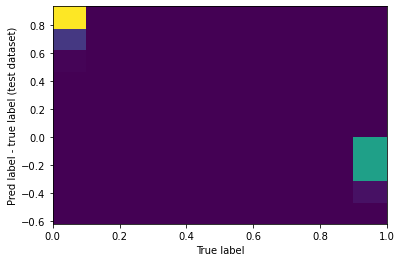

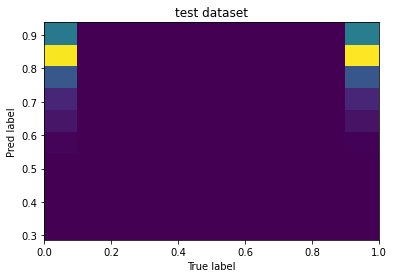

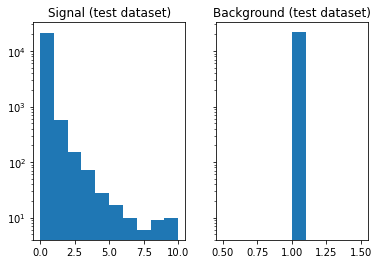

In [24]:
from train_utils import *
plot_rel_pred(y_test, preds_test, 'test')
plot_pred(y_test, preds_test, 'test')

if score_test:
    plot_score(y_test, score_test, 'test')

plot_weights(X_test_wgt, y_test, 'test')

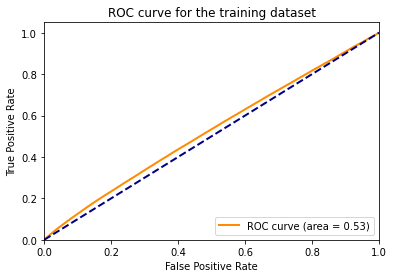

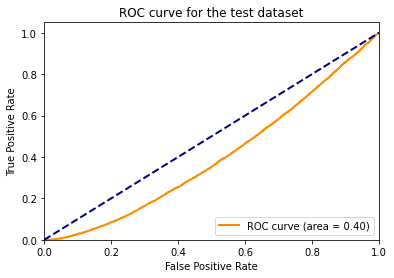

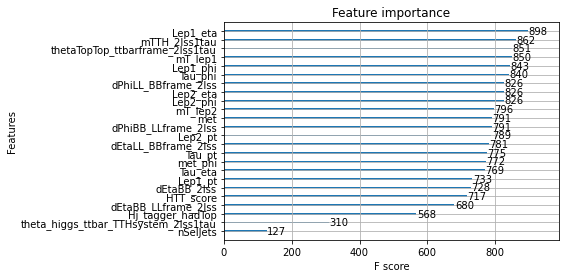

<Figure size 1152x864 with 0 Axes>

In [113]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                   num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)#

cv_results.head()

print((cv_results["test-rmse-mean"]).tail(1))

[18:34:05] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[18:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:05] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[18:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:05] DEBUG: ../src/gbm/gbtree.cc:147: Using tree method: 2
[18:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:34:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:34:06] INFO: .

[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[18:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned node

[18:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[18:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[18:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:34:18] ======== Monitor: Learner ========
[18:34:18] Configure: 0.000534s, 1 calls @ 534us

[18:34:18] EvalOneIter: 0.582356s, 50 calls @ 582356us

[18:34:18] GetGradient: 0.152019s, 50 calls @ 152019us

[18:34:18] PredictRaw: 0.000176s, 50 calls @ 176us

[18:34:18] UpdateOneIter: 2.7887s, 50 calls @ 2788703us

[18:34:18] ======== Monitor: GBTree ========
[18:34:18] BoostNewTrees: 2.63511s, 50 calls @ 2635107us

[18:34:18] CommitModel: 6.3e-05s, 50 calls @ 63us

[18:34:18] ======== Monitor: TreePruner ========
[18:34:18] PrunerUpdate: 0.014012s, 50 calls @ 14012us

[18:34:18] ======== Monitor: Learner ========
[18:34:18] Configure: 0.018768s, 1 call

In [111]:

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# CV model
model = xgb.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, weight=X_train_wgt,  cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


TypeError: cross_val_score() got an unexpected keyword argument 'weight'

In [107]:

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print("MSE: %f" % mean_squared_error(y_test,preds))



xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


#X = data[thevars]
#y =
#X, y = data.iloc[:,:-1],data.iloc[:,-1]


#xgmat <- xgb.DMatrix(data, label = label, weight = weight, missing = -999.0)

NameError: name 'preds' is not defined

In [ ]:
xgmat= xgb.DMatrix(data_dmatrix, label = y, weight = weight, missing = -999.0)
params = {"objective":"binary:logitraw",
          'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10,
            #"bst:eta": 0.1,
            #"bst:max_depth": 6,
            "eval_metric" : "auc",
            "nthread": 4}
          
watchlist = { "train" :xgmat}
nrounds = 120
print ("loading data end, start to boost trees")
bst = xgb.train(param, xgmat, nrounds, watchlist );
# save out model
xgb.save(bst, "higgCP.model")
print ('finish training')